# Flax-Pilot VAE-GAN-CFG MNIST Notebook

This notebook demonstrates the usage of flax-pilot to train a GAN model. The workflow uses distributed training using jax.pmap on Kaggle GPU

**Use TensorFlow-cpu instead of TensorFlow to avoid any issues between TensorFlow & Jax.**

In [1]:
!pip install -q tensorflow-cpu

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.
tensorflow 2.15.0 requires ml-dtypes~=0.2.0, but you have ml-dtypes 0.3.2 which is incompatible.
tensorflow 2.15.0 requires tensorboard<2.16,>=2.15, but you have tensorboard 2.16.2 which is incompatible.


In [2]:
!pip install mergedeep

In [3]:
import jax
import optax
import functools
import tensorflow as tf
import flax.linen as nn
import jax.numpy as jnp
import jax.random as jr
from mergedeep import merge as dmerge

In [4]:
import jax, flax, orbax.checkpoint
jax.__version__, flax.__version__, orbax.checkpoint.__version__

('0.4.26', '0.8.4', '0.5.15')

### Create a VAE-GAN-CFG Model.

*Note: The main model must always have a '**deterministic**' param to handle layers like dropout. Not adding '**deterministic**' param will lead to error as flax-pilot always expects this param, irrespective of whether the model has any stochastic layers or not.*

In [43]:
class Discriminator(nn.Module):
    @nn.compact
    def __call__(self, x, deterministic):
        x = nn.Conv(features=64, kernel_size=(5, 5), strides=(2, 2), padding='SAME')(x)
        x = nn.leaky_relu(x)
        x = nn.Dropout(0.3, deterministic=deterministic)(x)
        
        x = nn.Conv(features=128, kernel_size=(5, 5), strides=(2, 2), padding='SAME')(x)
        x = nn.leaky_relu(x)
        x = nn.Dropout(0.3, deterministic=deterministic)(x)
        
        x = x.reshape((x.shape[0], -1)) 
        x = nn.Dense(features=16)(x)
        return x


class Encoder(nn.Module):
    @nn.compact
    def __call__(self, x, deterministic):
        x = nn.relu(nn.Conv(features=64, kernel_size=(3, 3), strides=2, padding='SAME')(x))
        x = nn.relu(nn.Conv(features=128, kernel_size=(3, 3), strides=2, padding='SAME')(x))
        x = x.reshape(x.shape[0], -1)
        x = nn.Dropout(0.3, deterministic=deterministic)(nn.Dense(32)(x))
        mean = nn.Dense(2)(x)
        logvar = nn.Dense(2)(x)
        return mean, logvar

class Decoder(nn.Module):
    def setup(self,):
        self.cls_embedding = nn.Embed(10, 128)
    
    @nn.compact
    def __call__(self, z, c, deterministic):
        y = nn.relu(nn.Dense(49*128)(z))
        c = self.cls_embedding(c.astype(jnp.int32))
        
        y = y.reshape(y.shape[0], 7, 7, 128)
        y += c[:, None, None, :]
        y = nn.GroupNorm()(y)
        
        y = nn.gelu(nn.ConvTranspose(features=128, kernel_size=(3, 3), strides=2, padding='SAME')(y))
        y += c[: ,None, None, :]
        y = nn.GroupNorm()(y)
        
        y = nn.gelu(nn.ConvTranspose(features=64, kernel_size=(3, 3), strides=2, padding='SAME')(y))
        y += (nn.Dropout(0.3, deterministic=deterministic)(nn.Dense(64)(c))[:, None, None, :])
        y = nn.GroupNorm()(y)
        
        y = nn.ConvTranspose(features=1, kernel_size=(3, 3), padding='SAME')(y)
        y = nn.sigmoid(y)
        return y
        
        
class VAE(nn.Module):
    def setup(self,):
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    @nn.compact
    def __call__(self, x, c, deterministic):
        mean, logvar = self.encode(x, deterministic)
        z = self.reparam_trick(mean, logvar)
        y = self.decode(z, c, deterministic)
        return (mean, logvar), y
        
    def encode(self, x, deterministic):
        return self.encoder(x, deterministic)
    
    def decode(self, x, c, deterministic):
        return self.decoder(x, c, deterministic)
    
    def reparam_trick(self, mean, logvar):
        e = jr.normal(self.make_rng('normal'), mean.shape)
        return mean + jnp.exp(0.5*logvar)*e

#### Training objectives
   - **Generator** i.e. VAE. Model Name
   - **Discriminator**

#### Encapsulate both the sub-models inside a single model

The sub-model's object name `generator` and `discriminator` must be noted as these names will be used to target params of the sub-models by their respective optimizer.

In [44]:
class GAN(nn.Module):
    def setup(self,):
        self.discriminator = Discriminator()
        self.generator = VAE()
    
    @nn.compact
    def __call__(self, x, c, deterministic):
        (mean, logvar), y = self.generator_call(x, c, deterministic)
        dtrue = self.disc(x, deterministic)
        dfake = self.disc(y, deterministic)
        return y, mean, logvar, dtrue, dfake
    
    def generator_call(self, x, c, deterministic):
        return self.generator(x, c, deterministic)
    
    def decode(self, x, c, deterministic):
        return self.generator.decode(x, c, deterministic)
    
    def disc(self, x, deterministic):
        return self.discriminator(x, deterministic)

### Create tf.data.Dataset
Distributed training in this notebook is performed using jax.pmap. jax.pmap expects the first dimension of its input tensor as the number of devices in parallel.<br>
<br> 
So Input tensor must have shape **(NO_OF_DEVICES, LOCAL_BATCH_SIZE, ...)**<br>
MNIST Images have shape : **(28, 28, 1)**<br>
In this case, input shape will be : **(2, 128, 28, 28, 1)**. So, we have 2 devices, each device will receive a batch of shape **(128, 28, 28, 1)**.

GLOBAL_BATCH_SIZE = LOCAL_BATCH_SIZE * NO_OF_DEVICES<br>
In this case, GLOBAL_BATCH_SIZE = 256

In [45]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(256).batch(128, True)

def func(x, c):
    return x[:, :, :, None]/255, c
    
train_ds = train_ds.map(func, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(2, True)
train_ds = train_ds.repeat().as_numpy_iterator()

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.shuffle(256).batch(128, True)
val_ds = val_ds.map(func, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(2, True)
val_ds = val_ds.repeat().as_numpy_iterator()

train_ds, val_ds

(NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x78dc8d068820>),
 NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x78dc8d069ed0>))

### Loss Function

#### Inputs to the loss function

##### The `loss_fn` for multi-optimizing will always receive these seven specific inputs, described as follows:

1. **params**:
   - **Description**: The model's parameters.
   - **Obtained by**: Using the `init` method of `flax.linen.Module`.
   - **Example**: `params = model.init(prng_key, input_shape)`.



2. **apply**:
   - **Description**: The `apply` method from `flax.linen.Module`, used to call other methods within the module.



3. **sample**:
   - **Description**: The input data to the model.


4. **deterministic**:
   - **Description**: Indicates whether to enable deterministic behavior in layers (similar to the `training` parameter in Keras).
   - **Usage**: 
     - Set to `True` during validation (`val_step`), where dropout is disabled.
     - Set to `False` during training (`train_step`).



5. **global_key**:
   - **Description**: A PRNGKey used to seed random variables, important for dropout and other random operations within the model.
   - **Management**: 
     - Updated using `jax.fold_in` within the `train_step` and `val_step` functions to ensure a unique key for each step.
     - When flax model requires multliple keys in its forward pass, the global prng key received here can be splitted into multliple prng keys using `jax.random.split`. These splits can be represented as a dict where keys of the dict are the `rng_name` used from within the model using `self.make_rng(rng_name)` and value as the prng key itself.
     - From within the model, prng keys can be accessed by `self.make_rng(rng_name)`.
     
     
    
6. **step**:
   - **Description**: Represents the current iteration or step number of the optimizer during training.
   - **Usage**: Can be used to weigh losses based on the current number of iterations. For example, it allows implementing techniques like annealing the KL divergence weight in a variational autoencoder or any other time-dependent adjustments during training.
   - **Management**:
     - Passed directly to the `loss_fn` within the `train_step` and `val_step` functions.
     - It is incremented at each iteration of the training loop.
     - Enables dynamic adjustments of the loss function or other training parameters as training progresses, offering more fine-grained control over the training process.
     
     
     
7. **obj**:
   - **Description**: A string that specifies which sub-model's objective function does the optimizers wants the loss function to return. This loss_fn will be called iteratively with each time passed with different sub-model's object name to return the objective function to optimize that specific sub-model. So `if` condition is a must in multi-optimizing training, so that the loss function returns the loss function steps for that specific model to the optimizer. The values that `obj` receives iteratively here will be the key names of the optimizer dict declared in the later cells which must be same as the sub-model's object name inside the encapsulated model.

   - **Usage**: 
     - If `obj == 'generator'`, the function calculates and returns the generator's loss, which includes the reconstruction loss, KL divergence loss, and generator feature matching loss.
     - If `obj == 'discriminator'`, the function calculates and returns the discriminator's loss, which includes the discriminator's loss on real and fake data.



### Note:
- All these seven parameters are crucial for multi-optimization training and must not be removed or replaced.
- In case of single optimizing, one must simply not add `obj` to the params of these function. Presence of `obj` during single optimizing will raise a error.
- Their names can be changed, but their order and functionality must remain the same.



This structure ensures that the `loss_fn` receives all necessary inputs in a consistent manner, facilitating proper model training and evaluation.

#### Outputs from the loss function

The function must return two elements:

1. **Scalar loss**:
   - **Description**: The value which should be minimized.
   - **Details**: This scalar is minimized with respect to the first parameter of the function, `params`.



2. **loss_metric_values_dict**:
   - **Description**: A dictionary that must always contain two keys, **'mt'** (metric tracker) and **'lt'** (loss tracker).
   - **Structure**:
     - Each of these parent keys must hold a child dictionary as its value, representing different metric and loss trackers.
     - The child dictionary's key names can be any string but must match with the tracker instances dictionary (explained in later cells).
     - The child dictionary's values must be the values being tracked.
   - **Details**:
     - For losses, the loss tracker is used to track the losses, so the child dictionaries of **'lt'** must have scalar loss as their values.
     - For classification metrics like Accuracy or F1Score, the child dictionary of **'mt'** will expect a tuple of `(y_true, y_pred)` as its value or a dictionary like `{'true': true, 'pred': pred}` as its value.
     - These values of child dict are passed to the `update` function of tracker instances. Check out `trackers.py` to understand the expected inputs of each tracker's update function.

#### Important point about loss function below.
The data declared globally outside the loss function for the loss function must be constants, because the loss function will be pmapped which causes `jit` hence, must be a pure function. So members like `disc_start`, `disc_weight`, `disc_factor_4_gen` must not be changed. These constants are used to weigh the loss function and they can be used with `step` arg received for dynamic weighing.

#### Example Warmup weighed loss function
```python
warmup_steps = 1000
w_0 = 0.2
w_t = 0.9

# Single optimizing 
def loss_fn((params, apply, sample, deterministic, global_key, step):
    output = apply(params, sample, deterministic, rngs={'dropout': global_key})
    loss = L(output) # compute_loss
    weight = ((step<warmup_steps)*(w_0 + (step/warmup_steps)*(w_t-w_0))) + (step>=warmup_steps)*w_t
    loss = loss*weight
    return loss, {'lt': {}, 'mt':{}}
    
```

In [60]:
disc_start = 10000
disc_weight = 0.7
disc_factor_4_gen=0.3


def loss_fn(params, apply, sample, deterministic, global_key, step, obj):
    x, c = sample
    y, mean, logvar, dt, df = apply(params, x, c, deterministic=deterministic, rngs={'dropout': global_key, 'normal': global_key})

    if obj=='generator':
        recons_loss = -(x*jnp.log(y+0.00001) + (1-x)*jnp.log((1-y)+0.00001)).sum(axis=(1, 2)).mean()
        kl_loss = (-0.5 * (1 + logvar - jnp.square(mean) - jnp.exp(logvar))).sum(axis=(1, )).mean()
        gen_df_loss = -df.mean()
        loss = recons_loss + (kl_loss) + (gen_df_loss*disc_factor_4_gen)
        gen_loss = loss  
        
        return gen_loss, {
            'lt': {'recons_loss': recons_loss, 'kl_loss': kl_loss, 'gen_loss': gen_df_loss}, 
            'mt': dict()
        }

    if obj=='discriminator':
        disc_dt_loss = nn.relu(1.0 - dt).mean()
        disc_df_loss = nn.relu(1.0 + df).mean()
        disc_loss = 0.5* (disc_dt_loss + disc_df_loss)
        
        # Dynamic weighing
        weight = (step >= disc_start)*disc_weight
        disc_loss = disc_loss*weight
        
        return  disc_loss, {
            'lt': {'dict_true_op': dt.mean(), 'dict_fake_op': df.mean()}, 
            'mt': dict()
        }

### Access to the modules

In [47]:
import os
os.listdir("/kaggle/input/fpilot")

['trackers', 'checkpoints', 'training']

In [48]:
import glob, sys
sys.path.append("/kaggle/input")

### Creating tracker functions

Trackers are represented in a dictionary, with keys **'mt'** (metric tracker) and **'lt'** (loss tracker) being mandatory. Each of these keys must have a child dictionary as its value. The child dictionary's key names must match the child key names in `loss_metric_values_dict`. The value of the child dictionaries must be tracker instances.


In [49]:
from fpilot.trackers import basic_trackers as tr

In [50]:
trackers = {
        'lt': {'recons_loss': tr.Mean(), 'kl_loss': tr.Mean(), 'gen_loss': tr.Mean(), 'dict_true_op': tr.Mean(), 'dict_fake_op': tr.Mean()},
        'mt':{}
}

### Trainer

The `Trainer` instance takes in five parameters:

1. **flax_model**:
   - **Description**: A `flax.linen.Module` instance.



2. **input_shape**:
   - **Description**: Shapes of input tensors passed to the model.
   - **Type**: A dictionary where the key is the parameter name of the model's `__call__` method and the value is the shape of the tensor.



3. **optimizer**:
   - **Description**: 
     - In single-objective training: It must be a single Optax optimizer. This optimizer is applied uniformly to all model parameters to minimize the loss function.
     - In multi-objective training (e.g., GANs): It must be a dictionary of optimizers. The keys of this dictionary correspond object names of the sub-models inside the encapsulated model that need to be optimized, and the values are the respective Optax optimizers for those parameters. This allows different sets of parameters to be optimized with different strategies.



4. **loss_metric_fn**:
   - **Description**: The loss function as explained above.



5. **trackers**:
   - **Description**: A dictionary of trackers as explained in the previous cell.

In [51]:
from fpilot.training.trainer import Trainer

#### Optimizers
- While passing optimizer for multi-optimization, one must pass the optimizers as dict where the key is the name of sub-model and value is the optimizer used to optimize that sub-model.
- So, the sub-model's names across the encapsulated model, loss_fn, the optimizer dict here must match.

In [52]:
trainer = Trainer(GAN(), {'x': (1, 28, 28, 1), 'c': (1, )}, {'discriminator': optax.adam(4e-5), 'generator': optax.adam(4e-5)}, loss_fn, trackers)

Check the docstring of **Trainer.train** for explaination 

In [54]:
trainer.train(3, train_ds, val_ds, 60000//256, 10000//256, "/kaggle/working/vae-gans-cfg/model_2", 1)

Epoch 1: 100%|██████████| 234/234 [00:07<00:00, 30.09it/s]


Train:  dict_fake_op: 0.061273858, dict_true_op: 0.055439588, gen_loss: -0.061273858, kl_loss: 4.5300837, recons_loss: 215.22287, time: 7.778534650802612
Val:  dict_fake_op: 0.059855796, dict_true_op: 0.057321936, gen_loss: -0.059855796, kl_loss: 4.8552165, recons_loss: 196.89456, time: 4.566174745559692
State saved..


Epoch 2: 100%|██████████| 234/234 [00:07<00:00, 30.10it/s]


Train:  dict_fake_op: 0.05844085, dict_true_op: 0.055188976, gen_loss: -0.05844085, kl_loss: 4.277618, recons_loss: 191.94191, time: 7.777907609939575
Val:  dict_fake_op: 0.061057992, dict_true_op: 0.05727289, gen_loss: -0.061057992, kl_loss: 4.4776144, recons_loss: 185.0398, time: 0.4808037281036377
State saved..


Epoch 3: 100%|██████████| 234/234 [00:07<00:00, 29.73it/s]


Train:  dict_fake_op: 0.058272764, dict_true_op: 0.055384524, gen_loss: -0.058272764, kl_loss: 4.210181, recons_loss: 180.77179, time: 7.875217437744141
Val:  dict_fake_op: 0.061696947, dict_true_op: 0.057875484, gen_loss: -0.061696947, kl_loss: 4.4503202, recons_loss: 174.63208, time: 0.4874765872955322
State saved..


### Access any method of the model

To access methods of the model, one can call the Trainer instance. **Check docstring to understand its working.**

1. **PRNGKey Dictionary**:
   - **Description**: A dictionary where the values are `jax.random.PRNGKey` instances and the keys are the names used inside the model to reference these PRNGKeys.



2. **Tensor Inputs**:
   - **Description**: The tensor inputs passed to the model's method you plan to call.
   - **Type**: A dictionary where each key is the name of a method parameter and each value is the corresponding tensor input.
   - **Note**: Tensor inputs must include a device dimension due to `jax.pmap` decoration, e.g., `(NO_OF_DEVICES, LOCAL_BATCH_SIZE, ...)`.



3. **Method Name**:
   - **Description**: A string representing the method of the model you plan to call.
   - **Default**: The default value is the `__call__` method.



4. **kwargs**:
   - **Description**: Used to pass any static arguments to the method, such as the `deterministic` parameter.



Below are some examples.

*Note: Tensor inputs to methods are jax.pmap decorated so, inputs must include device dimension. For ex. __(NO_OF_DEVICES, LOCAL_BATCH_SIZE, ...)__*

#### Model call
The callable Trainer function accepts param '**method**' which represents the which method of the model to call. Default value is the **call** method.

In [37]:
img, label  = next(val_ds)

rngs = {'normal': jax.random.PRNGKey(12)}
tensor_inputs = {'c': label, 'x': img}

output = trainer(rngs, tensor_inputs, deterministic=True)

#### Model.decode

In [58]:
rand = jr.normal(jr.PRNGKey(23), (2, 50, 2))

c = jnp.array([
    jnp.full((10, ), i) for i in range(10)
]).reshape(2, 50)

rngs = {'normal': jax.random.PRNGKey(18)}

tensor_inputs = {'x': rand, 'c': c}
output = trainer(rngs, tensor_inputs, method='decode', deterministic=True)

### Evaluate the model

In [ ]:
trainer.evaluate(val_ds, 10000//256)

### Compute trackers

In [ ]:
trainer.compute_trackers()

### Save & Load checkpoints

In [65]:
# args: location to save checkpoint
trainer.save_state('/kaggle/working/vae-gans-cfg/model')

State saved..


In [57]:
# args: path to saved checkpoint folder, step number of checkpoint to restore
trainer.load_state('/kaggle/working/vae-gans-cfg/model', 81512)

### Visualize results

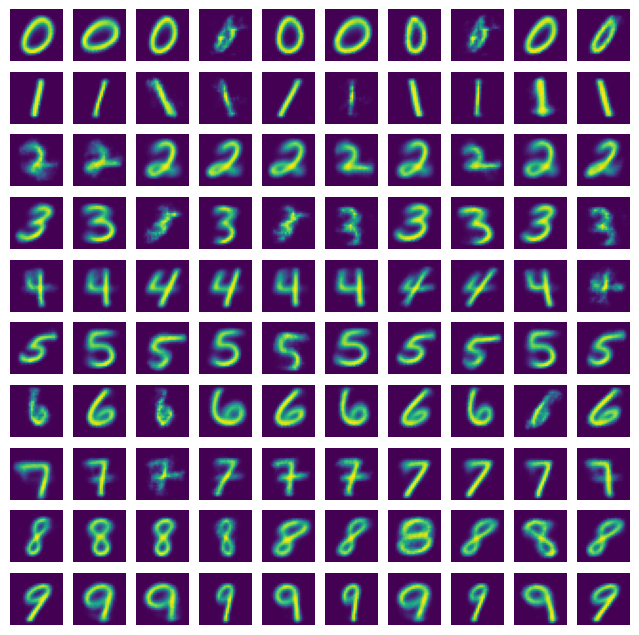

In [59]:
import matplotlib.pyplot as plt

x = output.reshape(100, 28, 28, 1)

plot_images = iter(x)
fig, ax = plt.subplots(10, 10, figsize=(8, 8))

for i in range(10):
    for j in range(10):
        ax[i][j].imshow(next(plot_images))
        ax[i][j].axis('off')